## Современные библиотеки градиентного бустинга

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* **XGBoost**. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Одними из основных особенностей имплементации были оптимизированность построения деревьев, а также различные регуляризации модели.
* **LightGBM**. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O(\text{#bins})$. Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Таким образом, каждое дерево является цепочкой с прикрепленными листьями.
* **CatBoost**. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки (даже если их значения представлены в виде строк). Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

### Основные параметры

(lightgbm/catboost)

* `objective` – функционал, на который будет настраиваться композиция
* `eta` / `learning_rate` – темп (скорость) обучения
* `num_iterations` / `n_estimators`  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* `max_depth` – максимальная глубина 
* `max_leaves` / num_leaves – максимальное число вершин в дереве
* `gamma` / `min_gain_to_split` – порог на уменьшение функции ошибки при расщеплении в дереве
* `min_data_in_leaf` – минимальное число объектов в листе
* `min_sum_hessian_in_leaf` – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* `lambda` – коэффициент регуляризации (L2)
* `subsample` / `bagging_fraction` – какую часть объектов обучения использовать для построения одного дерева 
* `colsample_bytree` / `feature_fraction` – какую часть признаков использовать для построения одного дерева 

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: `learning_rate` и `n_estimators`. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют `n_estimators=1000` и подбирают `learning_rate`). Следующим по важности является `max_depth`. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


plt.style.use('seaborn')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

In [2]:
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

In [3]:
# !pip install mlxtend

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

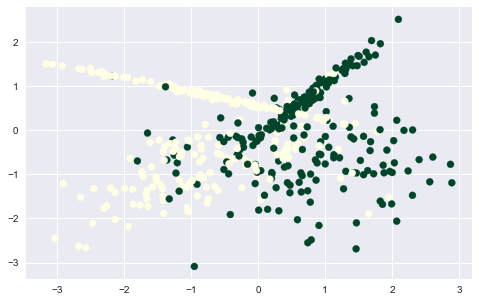

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='YlGn');

## Catboost

In [6]:
from catboost import CatBoostClassifier
#??CatBoostClassifier

#### Задание 1. 
- Обучите CatBoostClassifier с дефолтными параметрами, используя 300 деревьев. 
- Нарисуйте decision boundary
- Посчитайте roc_auc_score

0.919452347083926


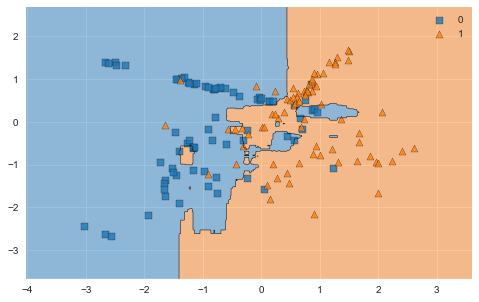

In [7]:
from sklearn.metrics import roc_auc_score
from mlxtend.plotting import plot_decision_regions

# YOUR CODE HERE
clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_decision_regions(X_test, y_test, clf)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

### Learning rate

Default is 0.03

#### Задание 2. 
- Обучите CatBoostClassifier с разными значениями `learning_rate`. 
- Посчитайте roc_auc_score на тестовой и тренировочной выборках
- Написуйте график зависимости roc_auc от скорости обучения (learning_rate)

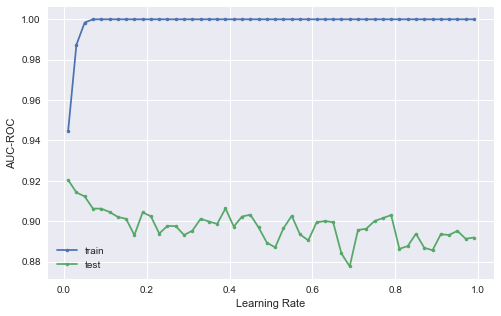

In [8]:
lrs = np.arange(0.01, 1, 0.02)
quals_train = [] # to store roc auc on trian
quals_test = [] # to store roc auc on test

for l in lrs:
    # YOUR CODE HERE
    clf = CatBoostClassifier(iterations=300, logging_level='Silent', learning_rate=l)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
# YOUR CODE HERE (make the plot)
plt.plot(lrs, quals_train, marker='.', label='train')
plt.plot(lrs, quals_test, marker='.', label='test')
plt.xlabel('Learning Rate')
plt.ylabel('AUC-ROC')
plt.legend()

### Number of trees

Важно также подобрать количество деревьев

#### Задание 3. 
- Обучите CatBoostClassifier с разными значениями `iterations`. 
- Посчитайте roc_auc_score на тестовой и тренировочной выборках
- Написуйте график зависимости roc_auc от размера копозиции

In [9]:
# %%timeit
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent', learning_rate=0.01)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

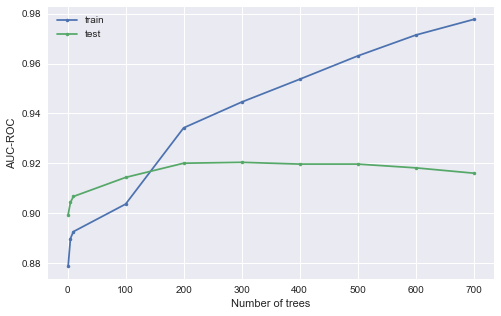

In [10]:
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

### Staged prediction

Как сделать то же самое, но быстрее. Для этого в библиотеке CatBoost есть метод `staged_predict_proba`

In [11]:
# %%timeit

# train the model with max trees
clf = CatBoostClassifier(iterations=700, 
                         logging_level='Silent',
                         learning_rate = 0.01)
clf.fit(X_train, y_train)

# obtain staged predictiond on test
predictions_test = clf.staged_predict_proba(
    data=X_test,
    ntree_start=0, 
    ntree_end=700, 
    eval_period=25
)

# obtain staged predictiond on train
predictions_train = clf.staged_predict_proba(
    data=X_train,
    ntree_start=0, 
    ntree_end=700, 
    eval_period=25
)

# calculate roc_auc
quals_train = []
quals_test = []
n_trees = []
for iteration, (test_pred, train_pred) in enumerate(zip(predictions_test, predictions_train)):
    n_trees.append((iteration+1)*50)
    quals_test.append(roc_auc_score(y_test, test_pred[:, 1]))
    quals_train.append(roc_auc_score(y_train, train_pred[:, 1]))

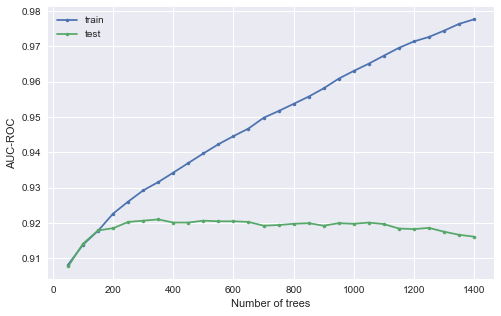

In [12]:
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

In [6]:
from lightgbm import LGBMClassifier
# ??LGBMClassifier

#### Задание 4. 
- Обучите LGBMClassifier с дефолтными параметрами, используя 300 деревьев. 
- Нарисуйте decision boundary
- Посчитайте roc_auc_score

In [ ]:
clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_decision_regions(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

Теперь попробуем взять фиксированное количество деревьев, но будем менять максимальнyю глубину

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


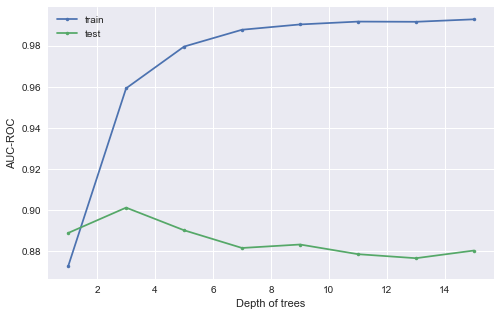

In [49]:
depth = list(range(1, 17, 2))
quals_train = []
quals_test = []
for d in depth:
    lgb = LGBMClassifier(n_estimators=100, max_depth=d)
    lgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

И сравним с Catboost:

#### Задание 5. 
- Обучите CatBoostClassifier с разной глубиной
- Посчитайте roc_auc_score, 
- Сравните лучший результат с LGBM

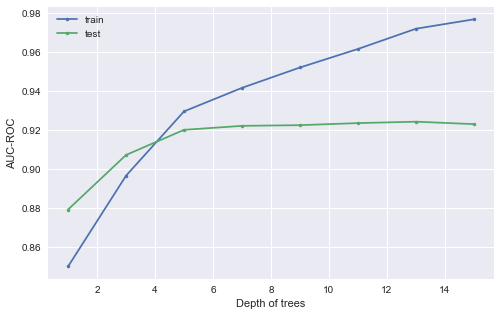

In [50]:
depth = list(range(1, 17, 2))

# YOUR CODE HERE
quals_train = []
quals_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=200, learning_rate=0.01, 
                             max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

Теперь, когда у нас получились отличные модели, нужно их сохранить!

In [46]:
clf = CatBoostClassifier(n_estimators=200, learning_rate=0.01, 
                         max_depth=5, logging_level="Silent")
clf.fit(X_train, y_train)
clf.save_model('catboost.cbm', format='cbm');

In [51]:
lgb = LGBMClassifier(n_estimators=100, max_depth=3)
lgb.fit(X_train, y_train)
lgb.booster_.save_model('lightgbm.txt')

И загрузим обратно, когда понадобится их применить

In [26]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

## Блендинг и Стекинг

Блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов. 

Рассмотрим простой пример блендинга бустинга и линейной регрессии.

In [53]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#### Задание 6. 
- Обучите CatBoostRegressor со следующими гиперпараметрами:
`iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE'`
- Посчитайте предсказание и RMSE на тестовой и тренировочной выборках

In [56]:
from catboost import CatBoostRegressor

# YOUR CODE HERE
cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % mean_squared_error(y_train, y_train_pred_cbm, squared=False))
print("Test RMSE GB = %.4f" % mean_squared_error(y_test, y_pred_cbm, squared=False))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


#### Задание 7. 
- Отмасштабируйте данные (StandardScaler) и обучите линейную регрессию
- Посчитайте предсказание и RMSE на тестовой и тренировочной выборках

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# YOUR CODE HERE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % mean_squared_error(y_train, y_train_pred_lr, squared=False))
print("Test RMSE LR = %.4f" % mean_squared_error(y_test, y_pred_lr, squared=False))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


#### Блендинг

Будем считать, что новый алгоритм $a(x)$ представим как
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum\limits_{n=1}^N w_n =1$

Нам нужно обучить линейную регрессию на предсказаниях двух обченных выше алгоритмов

#### Задание 8. 


In [70]:
predictions_train = pd.DataFrame([y_train_pred_lr, y_train_pred_cbm]).T
predictions_test =  pd.DataFrame([y_pred_lr, y_pred_cbm]).T

lr_blend = LinearRegression()
lr_blend.fit(predictions_train, y_train)

y_pred_blend = lr_blend.predict(predictions_test)
y_train_pred_blend = lr_blend.predict(predictions_train)

print("Train RMSE Blending = %.4f" % mean_squared_error(y_train, y_train_pred_blend, squared=False))
print("Test RMSE Blending = %.4f" % mean_squared_error(y_test, y_pred_blend, squared=False))

Train RMSE Blending = 3.4792
Test RMSE Blending = 4.2950


#### Стекинг

Теперь обучим более сложную функцию композиции

$$
 a(x) = f(b_1(x), b_2(x))
$$

где $f()$ это обученная модель градиентного бустинга

#### Задание 9. 


In [71]:
from lightgbm import LGBMRegressor


lgb_stack = LGBMRegressor(n_estimators=100, max_depth=2)
lgb_stack.fit(predictions_train, y_train)


y_pred_stack = lgb_stack.predict(predictions_test)
y_train_pred_stack = lgb_stack.predict(predictions_train)

print("Train RMSE Stacking = %.4f" % mean_squared_error(y_train, y_train_pred_stack, squared=False))
print("Test RMSE Stacking = %.4f" % mean_squared_error(y_test, y_pred_stack, squared=False))

Train RMSE Stacking = 2.9734
Test RMSE Stacking = 4.2375


В итоге получаем качество на тестовой выборке лучше, чем у каждого алгоритма в отдельности.

Полезные ссылки:

* [Видео про стекинг](https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6)

## XGBoost

In [5]:
# based on https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV  
from sklearn import metrics

In [9]:
titanic = pd.read_csv('titanic.csv')

In [10]:
X = titanic[['Pclass', 'Age', 'SibSp', 'Fare']]
y = titanic.Survived.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 4), (712,), (179, 4), (179,))

In [1]:
from xgboost.sklearn import XGBClassifier
# ??XGBClassifier

In [2]:
def modelfit(alg, dtrain, y, X_test=None, y_test=None, test=True):    

    #Fit the algorithm on the data
    alg.fit(dtrain, y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy (Train): %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    if test:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:,1]
        print ("Accuracy (Test): %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
        print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    # plot feature importance          
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

These parameters are used to define the optimization objective the metric to be calculated at each step.


<table><tr>
<td> <img src="xgb.png" alt="Drawing" style="width: 700px;"/> </td>
</tr></table>

In [3]:
xgb1 = XGBClassifier(objective='binary:logistic',
                     eval_metric='auc',
                     learning_rate =0.1, 
                     n_estimators=1000,
                     booster='gbtree',
                     seed=27)

In [ ]:
modelfit(xgb1, X_train, y_train, X_test, y_test)

#### Задание 10. 
- Задайте сетку для перечисленных ниже параметров

`max_depth` - Maximum tree depth for base learners.

`gamma`  - Minimum loss reduction required to make a further partition on a leaf node of the tree.

`subsample` -  Subsample ratio of the training instance.

`colsample_bytree` - Subsample ratio of columns when constructing each tree.

`reg_alpha` - L1 regularization term on weights

- Запустите поиск, используя `GridSearchCV` c 5 фолдами. Используйте смесь из 100 деревьев.

In [ ]:
param_grid = {
 'max_depth':range(3, 10, 2),
 'gamma':[0, 0.1, 0.2, 0.4],
 'subsample':[0.6, 0.8, 1],
 'colsample_bytree':[0.6, 0.8, 1],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic',
                                                  eval_metric='auc',
                                                  learning_rate =0.1, 
                                                  n_estimators=100,
                                                  booster='gbtree',
                                                  seed=27), 
                        param_grid = param_grid, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5,
                        verbose=2)
gsearch1.fit(X_train, y_train);

In [96]:
gsearch1.best_params_, gsearch1.best_score_

({'colsample_bytree': 0.8,
  'gamma': 0.4,
  'max_depth': 3,
  'reg_alpha': 0.01,
  'subsample': 1},
 0.7472184390723717)


Model Report
Accuracy (Train): 0.7556
AUC Score (Train): 0.834611
Accuracy (Test): 0.743
AUC Score (Test): 0.828700


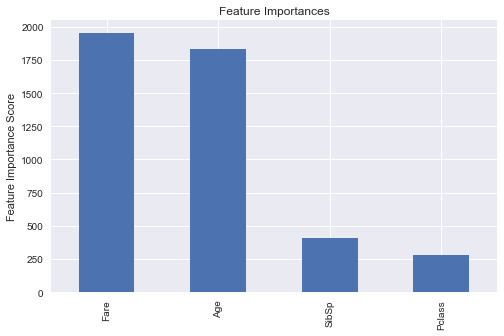

In [97]:
xgb_best = XGBClassifier(objective='binary:logistic',
                         eval_metric='auc',
                         learning_rate =0.01, 
                         n_estimators=1000,
                         booster='gbtree',
                         seed=27,
                         max_depth = gsearch1.best_params_['max_depth'],
                         gamma = gsearch1.best_params_['gamma'], 
                         subsample = gsearch1.best_params_['subsample'],
                         colsample_bytree = gsearch1.best_params_['colsample_bytree'],
                         reg_alpha = gsearch1.best_params_['reg_alpha']
                        )
modelfit(xgb_best, X_train, y_train, X_test, y_test)

## Важность признаков

В курсе мы подробно обсуждаем, как добиваться хорошего качества решения задачи: имея выборку $X, y$, построить алгоритм с наименьшей ошибкой. Однако заказчику часто важно понимать, как работает алгоритм, почему он делает такие предсказания. Обсудим несколько мотиваций.
	
#### Доверие алгоритму
Например, в банках на основе решений, принятых алгоритмом, выполняются финансовые операции, и менеджер, ответственный за эти операции, будет готов использовать алгоритм, только если он понимает, что его решения обоснованы. По этой причине в банках очень часто используют простые линейные алгоритмы. Другой пример из области медицины: поскольку цена ошибки может быть очень велика, врачи готовы использовать только интерпретируемые алгоритмы.
	
#### Отсутствие дискриминации (fairness) 
Вновь пример с банком: алгоритм кредитного скоринга не должен учитывать расовую принадлежность (racial bias) заемщика или его пол (gender bias). Между тем, такие зависимости часто могут присутствовать в датасете (исторические данные), на котором обучался алгоритм.  Еще один пример: известно, что нейросетевые векторы слов содержат gender bias. Если эти вектора использовались при построении системы поиска по резюме для рекрутера, то, например, по запросу `technical skill` он может видеть женские резюме в конце ранжированного списка.
	
#### Учет контекста
Данные, на которых обучается алгоритм, не отображают всю предметную область. Интерпретация алгоритма позволит оценить, насколько найденные зависимости связаны с реальной жизнью. Если предсказания интерпретируемы, это также говорит о высокой обобщающей способности алгоритма. 

Теперь обсудим несколько вариантов, как можно оценивать важность признаков.

### Веса линейной модели

Самый простой способ, который уже был рассмотрен на семинаре про линейные модели: после построения модели каждому признаку будет соответствовать свой вес - если признаки масштабированы, то чем он больше по модулю, тем важнее признак, а знак будет говорить о положительном или отрицательном влиянии на величину целевой переменной.

In [103]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

### FSTR (Feature strength)

[Fstr](https://catboost.ai/docs/concepts/fstr.html) говорит, что важность признака &mdash; это то, насколько в среднем меняется ответ модели при изменении значения данного признака (изменении значения разбиения).

Рассчитать его можно так:

$$feature\_importance_{F} = \sum_{tree, leaves_F} (v_1 - avr)^2\cdot c_1 +(v_2 - avr)^2\cdot c_2 = \left(v_1 - v_2\right)^2\frac{c_1c_2}{c_1 + c_2}\\
\qquad avr = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}.$$

Мы сравниваем листы, отличающиеся значением сплита в узле на пути к ним: если условие сплита выполняется, объект попадает в левое поддерево, иначе &mdash; в правое. 

$c_1, c_2$ - число объектов обучающего датасета, попавших в левое и правое поддерево соответственно, либо суммарный вес этих объектов, если используются веса; $v_1, v_2$ - значение модели в левом и правом поддереве (например, среднее)


Далее значения $feature\_importance$ нормируются, и получаются величины, которые суммируются в 100.

In [110]:
clf = CatBoostClassifier(n_estimators=200, learning_rate=0.01, 
                         max_depth=5, logging_level="Silent")

# load the trained catboost model
clf = clf.load_model('catboost.cbm')

In [111]:
for val, name in sorted(zip(cbm.feature_importances_, data.feature_names))[::-1]:
    print(name, val)

LSTAT 44.57842395824728
RM 36.850858175652654
NOX 3.473133901367306
PTRATIO 3.3887271637105134
DIS 2.23667053074621
INDUS 1.9016830079470277
TAX 1.7781003730136429
CRIM 1.5774334311195715
AGE 1.4213295189456003
RAD 1.3943420902109485
B 0.6521915521536685
CHAS 0.6057385942178969
ZN 0.14136770266764145


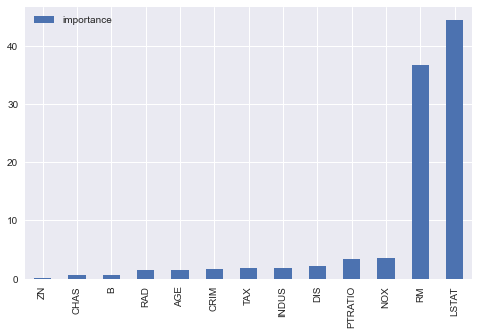

In [112]:
feature_importances = pd.DataFrame({'importance':cbm.feature_importances_}, index=data.feature_names)
feature_importances.sort_values('importance').plot.bar();

In [113]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Impurity-based feature importances

Важность признака рассчитывается как (нормированное) общее снижение критерия информативности за счет этого признака.

Приведем простейший пример, как можно получить такую оценку в sklearn-реализации RandomForest

In [114]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, oob_score=True)
clf.fit(X_train, y_train)

clf.feature_importances_

array([0.0347918 , 0.00057852, 0.00634385, 0.00144822, 0.02079838,
       0.39185139, 0.01321998, 0.06027615, 0.00416488, 0.01309993,
       0.01469631, 0.01288812, 0.42584248])

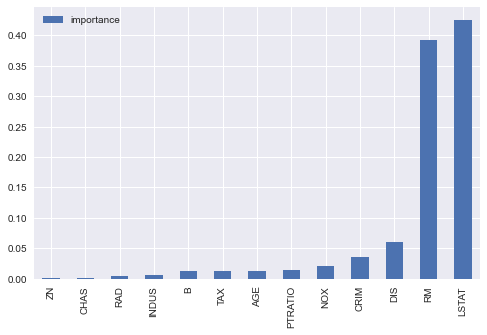

In [115]:
feature_importances = pd.DataFrame({'importance':clf.feature_importances_}, index=X_train.columns)
feature_importances.sort_values('importance').plot.bar();